<a href="https://colab.research.google.com/github/caaszj/GLAFormer/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
标签中的唯一值: [  0 255]
类别分布 - 未变化: 96694, 变化: 9321
标签中的唯一值: [  0 255]
类别分布 - 未变化: 96694, 变化: 9321
标签中的唯一值: [  0 255]
类别分布 - 未变化: 96694, 变化: 9321
检测到输入通道数: 198
数据样本形状: before=torch.Size([198, 9, 9]), after=torch.Size([198, 9, 9]), label=0
训练样本数: 74210
验证样本数: 15902
测试样本数: 15903
模型初始化完成，参数量: 21,816,258
类别权重: [ 1.       10.373779]
Epoch 1/5, Batch 20/145, Loss: 0.6225
Epoch 1/5, Batch 40/145, Loss: 0.5410
Epoch 1/5, Batch 60/145, Loss: 0.4960
Epoch 1/5, Batch 80/145, Loss: 0.4805
Epoch 1/5, Batch 100/145, Loss: 0.3898
Epoch 1/5, Batch 120/145, Loss: 0.3750
Epoch 1/5, Batch 140/145, Loss: 0.3522
Epoch 1/5, LR: 0.000001
  Train Loss: 0.4965
  Val Loss: 0.3666, Acc: 88.86%, F1: 0.5631, Kappa: 0.5064
  Val Confusion Matrix:
[[12988  1525]
 [  247  1142]]
  模型已保存: val_f1 从 0.0000 提升到 0.5631
Epoch 2/5, Batch 20/145, Loss: 0.2178
Epoch 2/5, Batch 40/145, Loss: 0.3044
Epoch 2/5, Batch 60/145, Loss: 0.3355
Epoch 2/5, Batch 80/145, Loss: 0.1663
Epoch 2/5, Batch 100/145, Loss: 0.1229
E

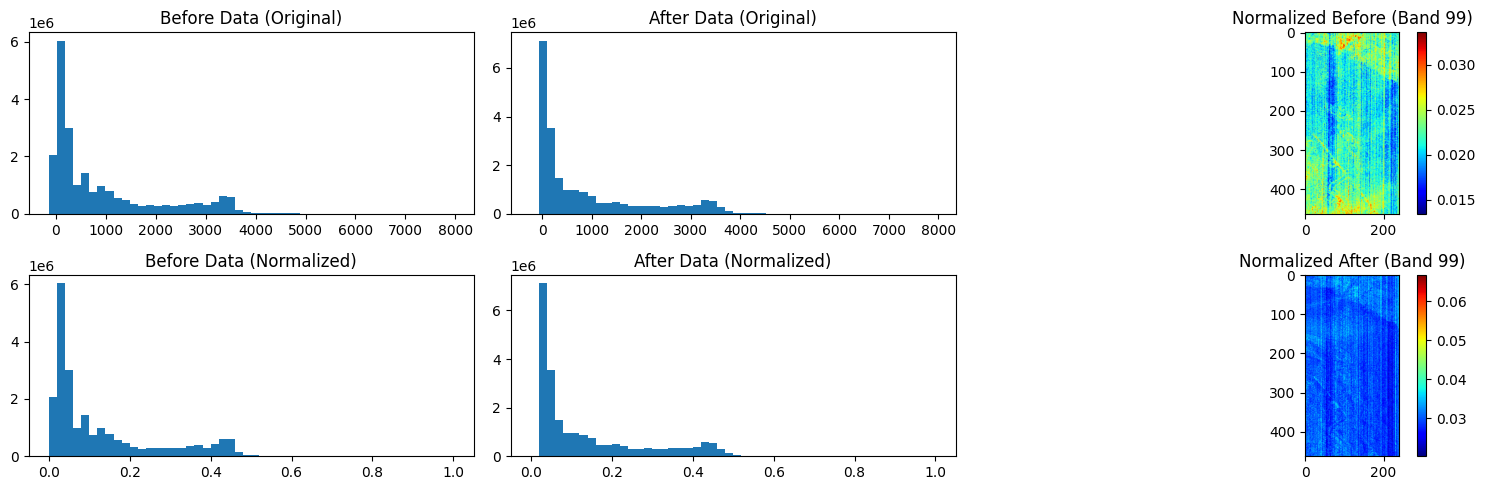

Generating Prediction: 100%|██████████| 1744/1744 [02:30<00:00, 11.59it/s]


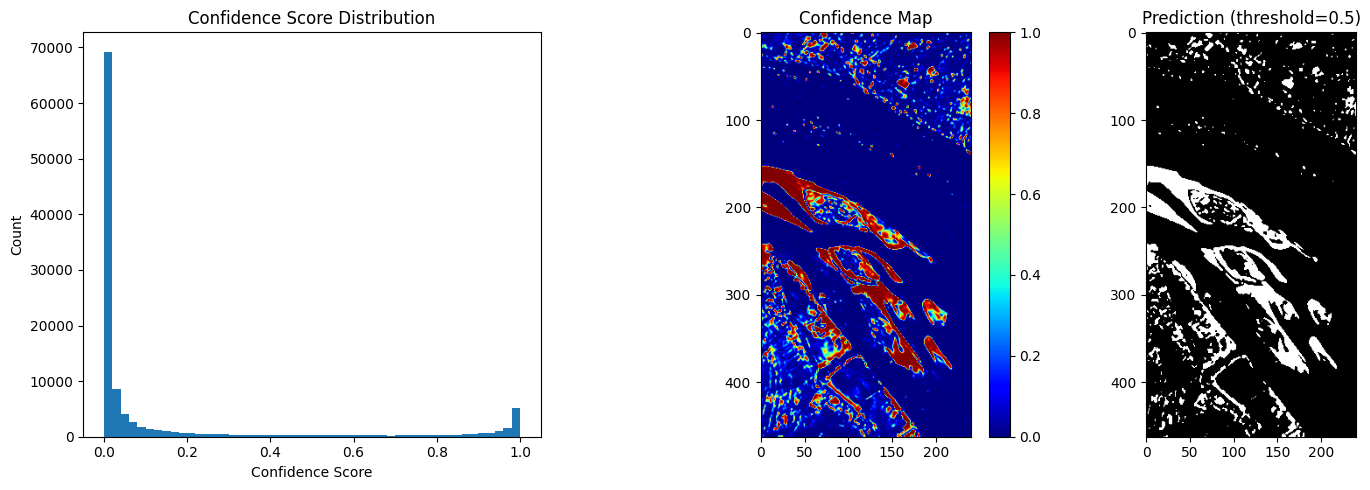


预测分析:
置信度范围: min=0.0005, max=0.9995
平均置信度: 0.1482
中位数置信度: 0.0082
变化像素比例（阈值0.5）: 13.24%


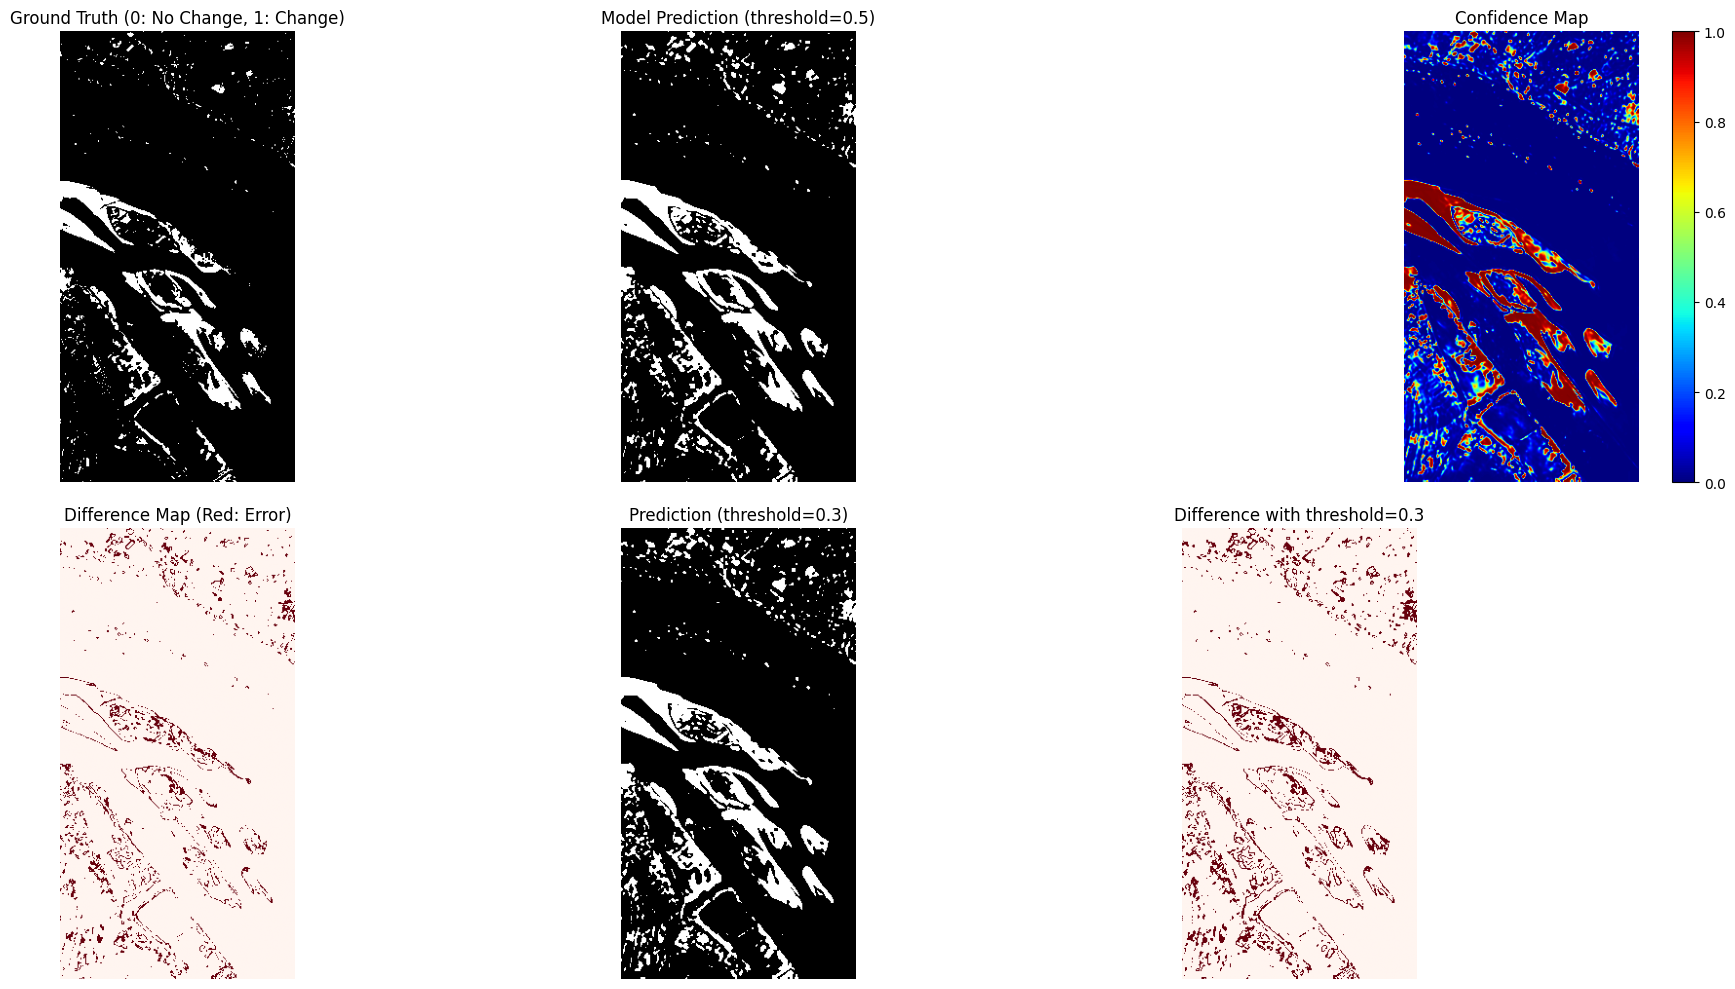


计算不同阈值下的性能指标...
阈值 0.1: 准确率=85.91%, F1=0.5505, Precision=0.3808, Recall=0.9930
阈值 0.2: 准确率=90.22%, F1=0.6369, Precision=0.4702, Recall=0.9869
阈值 0.3: 准确率=92.40%, F1=0.6918, Precision=0.5341, Recall=0.9819
阈值 0.4: 准确率=93.74%, F1=0.7301, Precision=0.5838, Recall=0.9740
阈值 0.5: 准确率=94.81%, F1=0.7635, Precision=0.6324, Recall=0.9633
阈值 0.6: 准确率=95.71%, F1=0.7933, Precision=0.6827, Recall=0.9467
阈值 0.7: 准确率=96.45%, F1=0.8191, Precision=0.7351, Recall=0.9248
阈值 0.8: 准确率=97.06%, F1=0.8404, Precision=0.7954, Recall=0.8909
阈值 0.9: 准确率=97.42%, F1=0.8457, Precision=0.8815, Recall=0.8126

最佳阈值: 0.9, F1=0.8457


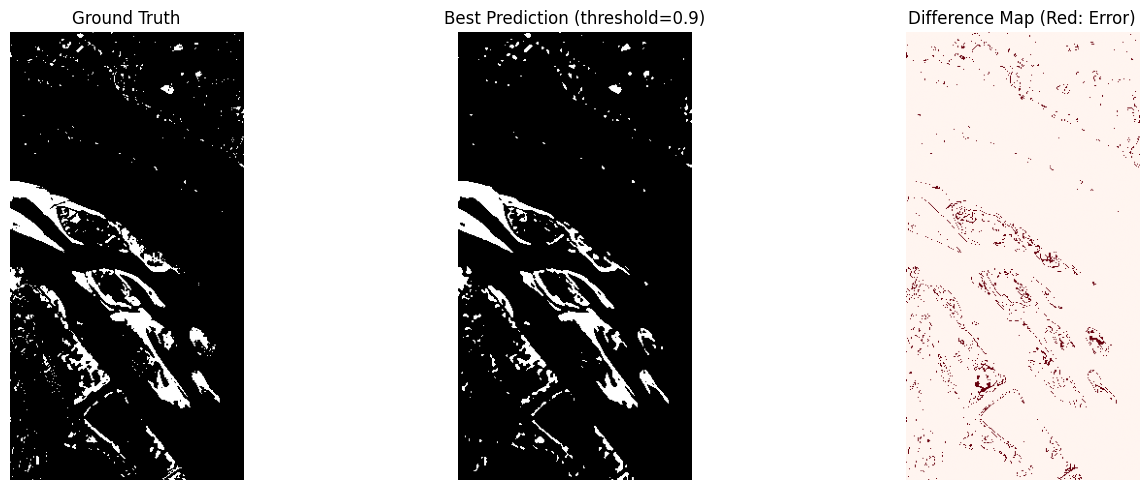

Using device: cuda
标签中的唯一值: [  0 255]
类别分布 - 未变化: 96694, 变化: 9321
标签中的唯一值: [  0 255]
类别分布 - 未变化: 96694, 变化: 9321
标签中的唯一值: [  0 255]
类别分布 - 未变化: 96694, 变化: 9321
检测到输入通道数: 198
数据样本形状: before=torch.Size([198, 9, 9]), after=torch.Size([198, 9, 9]), label=0
训练样本数: 74210
验证样本数: 15902
测试样本数: 15903
模型初始化完成，参数量: 21,816,258
类别权重: [ 1.       10.373779]


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.io import loadmat
from torch.utils.data import Dataset, DataLoader
import math
import os
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm

# 数据预处理和加载
class HSIChangeDetectionDataset(Dataset):
    def __init__(self, before_path, after_path, gt_path, patch_size=9, mode='train'):
        self.before = self.load_mat(before_path)  # (H, W, C)
        self.after = self.load_mat(after_path)
        self.gt = self.load_gt(gt_path)  # (H, W)

        # 检查标签值
        unique_labels = np.unique(self.gt)
        print(f"标签中的唯一值: {unique_labels}")

        # 归一化
        self.before = self._normalize(self.before)
        self.after = self._normalize(self.after)

        self.patch_size = patch_size
        self.half = patch_size // 2
        self.mode = mode

        # 生成有效位置索引
        self.coords = self.get_valid_coords()

        # 计算类别分布
        self.class_counts = self._get_class_distribution()
        print(f"类别分布 - 未变化: {self.class_counts[0]}, 变化: {self.class_counts[1]}")

        # 划分训练/验证/测试集
        np.random.seed(42)  # 设置随机种子以确保可重复性
        idx = np.random.permutation(len(self.coords))  # 随机打乱索引
        train_num = int(len(idx) * 0.7)  # 训练集占70%
        val_num = int(len(idx) * 0.15)  # 验证集占15%

        if mode == 'train':
            self.coords = self.coords[idx[:train_num]]  # 取前70%作为训练集
        elif mode == 'val':
            self.coords = self.coords[idx[train_num:train_num + val_num]]  # 取接下来的15%作为验证集
        else:
            self.coords = self.coords[idx[train_num + val_num:]]  # 剩下的15%作为测试集

    def _normalize(self, data):
        """安全的归一化函数，处理可能的零除问题"""
        data_min = np.min(data)
        data_max = np.max(data)
        if data_max == data_min:
            return np.ones_like(data) * 0.5  # 如果所有值相同，返回0.5而不是0
        normalized = (data - data_min) / (data_max - data_min)
        return np.clip(normalized, 0, 1)

    def _get_class_distribution(self):
        """计算变化/非变化类别的样本数量"""
        class_counts = [0, 0]
        for i, j in self.coords:
            label = 1 if self.gt[i, j] == 255 else 0
            class_counts[label] += 1
        return class_counts

    def load_mat(self, path):
        mat = loadmat(path)
        # 获取.mat文件中的第一个键，假设它是数据键
        keys = [k for k in mat.keys() if not k.startswith('__')]
        if 'river_before' in mat:
            return mat['river_before'].astype(np.float32)
        elif 'river_after' in mat:
            return mat['river_after'].astype(np.float32)
        elif len(keys) > 0:
            return mat[keys[0]].astype(np.float32)
        else:
            raise ValueError(f"无法从{path}加载数据")

    def load_gt(self, path):
        mat = loadmat(path)
        keys = [k for k in mat.keys() if not k.startswith('__')]
        if 'lakelabel_v1' in mat:
            return mat['lakelabel_v1'].astype(np.int64)
        elif len(keys) > 0:
            return mat[keys[0]].astype(np.int64)
        else:
            raise ValueError(f"无法从{path}加载标签")

    def get_valid_coords(self):
        H, W = self.gt.shape
        coords = []
        for i in range(self.half, H-self.half):
            for j in range(self.half, W-self.half):
                if self.gt[i, j] == 0 or self.gt[i, j] == 255:  # 只处理有效像素
                    coords.append((i, j))
        return np.array(coords)

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        i, j = self.coords[idx]
        # 提取双时相patch
        before_patch = self.before[i-self.half:i+self.half+1, j-self.half:j+self.half+1, :]
        after_patch = self.after[i-self.half:i+self.half+1, j-self.half:j+self.half+1, :]
        # 转为CHW格式
        before_patch = torch.from_numpy(before_patch).permute(2,0,1).float()
        after_patch = torch.from_numpy(after_patch).permute(2,0,1).float()
        label = 1 if self.gt[i, j] == 255 else 0  # 确保标签为0或1

        return before_patch, after_patch, label

# GLAM模块实现
class GLAM(nn.Module):
    def __init__(self, dim, num_heads=8, window_size=3):
        super().__init__()
        self.num_heads = num_heads

        # 确保维度可以被头数整除
        self.split_dim = dim // 2
        self.num_heads_local = max(1, num_heads // 2)  # 至少1个头
        # 确保head_dim_local是整数
        self.head_dim_local = self.split_dim // self.num_heads_local
        self.split_dim = self.head_dim_local * self.num_heads_local  # 重新计算以确保可整除

        self.window_size = window_size

        # Local分支
        self.local_qkv = nn.Conv2d(self.split_dim, self.split_dim*3, kernel_size=1)

        # Global分支
        self.global_q = nn.Conv2d(self.split_dim, self.split_dim, kernel_size=1)
        self.global_kv = nn.Conv2d(self.split_dim, self.split_dim*2, kernel_size=1)

        # 确保投影层维度正确
        self.proj = nn.Conv2d(self.split_dim*2, dim, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        # 分割通道维度
        x_split = torch.split(x, [self.split_dim, C - self.split_dim], dim=1)
        x_local = x_split[0]
        x_global = x_split[0] if len(x_split) == 1 else x_split[1]

        # 保证x_global的维度与split_dim一致
        if x_global.shape[1] != self.split_dim:
            x_global = F.adaptive_avg_pool2d(x_global, (H, W))
            x_global = F.interpolate(x_global, size=(H, W), mode='bilinear')
            if x_global.shape[1] > self.split_dim:
                x_global = x_global[:, :self.split_dim, :, :]
            elif x_global.shape[1] < self.split_dim:
                padding = self.split_dim - x_global.shape[1]
                x_global = torch.cat([x_global, torch.zeros(B, padding, H, W, device=x.device)], dim=1)

        # Local Attention
        qkv = self.local_qkv(x_local)  # [B, 3*split_dim, H, W]
        qkv = qkv.reshape(B, 3, self.num_heads_local, self.head_dim_local, H, W)
        q, k, v = qkv[:, 0], qkv[:, 1], qkv[:, 2]  # [B, num_heads_local, head_dim_local, H, W]

        # 重塑张量以计算注意力
        q = q.reshape(B, self.num_heads_local, self.head_dim_local, H*W)
        k = k.reshape(B, self.num_heads_local, self.head_dim_local, H*W)
        v = v.reshape(B, self.num_heads_local, self.head_dim_local, H*W)

        # 计算注意力分数 - 修正维度顺序
        attn = torch.matmul(q.transpose(-2, -1), k) / math.sqrt(self.head_dim_local)  # [B, num_heads_local, H*W, H*W]
        attn = F.softmax(attn, dim=-1)

        # 应用注意力
        local_out = torch.matmul(v, attn.transpose(-2, -1))  # [B, num_heads_local, head_dim_local, H*W]
        local_out = local_out.reshape(B, self.split_dim, H, W)

        # Global Attention
        x_pool = F.avg_pool2d(x_global, self.window_size)
        pool_H, pool_W = x_pool.shape[2], x_pool.shape[3]

        kv = self.global_kv(x_pool)  # [B, 2*split_dim, pool_H, pool_W]
        kv = kv.reshape(B, 2, self.num_heads_local, self.head_dim_local, pool_H, pool_W)
        k_g, v_g = kv[:, 0], kv[:, 1]  # [B, num_heads_local, head_dim_local, pool_H, pool_W]

        q_g = self.global_q(x_global)  # [B, split_dim, H, W]
        q_g = q_g.reshape(B, self.num_heads_local, self.head_dim_local, H, W)

        # 重塑张量以计算注意力
        q_g = q_g.reshape(B, self.num_heads_local, self.head_dim_local, H*W)
        k_g = k_g.reshape(B, self.num_heads_local, self.head_dim_local, pool_H*pool_W)
        v_g = v_g.reshape(B, self.num_heads_local, self.head_dim_local, pool_H*pool_W)

        # 计算注意力分数
        attn_g = torch.matmul(q_g.transpose(-2, -1), k_g) / math.sqrt(self.head_dim_local)  # [B, num_heads_local, H*W, pool_H*pool_W]
        attn_g = F.softmax(attn_g, dim=-1)

        # 应用注意力
        global_out = torch.matmul(v_g, attn_g.transpose(-2, -1))  # [B, num_heads_local, head_dim_local, H*W]
        global_out = global_out.reshape(B, self.split_dim, H, W)

        # 连接并投影
        out = torch.cat([local_out, global_out], dim=1)
        return self.proj(out)

# CGFN模块实现
class CGFN(nn.Module):
    def __init__(self, dim, expansion=4):
        super().__init__()
        hidden_dim = dim * expansion

        self.conv1 = nn.Conv2d(dim, hidden_dim, 1)
        self.dwconv3 = nn.Conv2d(hidden_dim, hidden_dim, 3, padding=1, groups=hidden_dim)
        self.dwconv5 = nn.Conv2d(hidden_dim, hidden_dim, 5, padding=2, groups=hidden_dim)
        self.conv2 = nn.Conv2d(hidden_dim*2, dim, 1)

        self.gate1 = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim, 1),
            nn.GELU(),
            nn.Conv2d(hidden_dim, hidden_dim, 1),
            nn.Sigmoid()
        )
        self.gate2 = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim, 1),
            nn.GELU(),
            nn.Conv2d(hidden_dim, hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x1 = self.dwconv3(x)
        x2 = self.dwconv5(x)

        g1 = self.gate1(x1)
        g2 = self.gate2(x2)

        x1 = x1 * g1 + x2
        x2 = x2 * g2 + x1
        x = torch.cat([x1, x2], dim=1)
        return self.conv2(x)

# 辅助模块
class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super().__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

# GLAFormer Block
class GLAFormerBlock(nn.Module):
    def __init__(self, dim, num_heads, window_size=3):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.glam = GLAM(dim, num_heads, window_size)
        self.norm2 = nn.LayerNorm(dim)
        self.cgfn = CGFN(dim)

    def forward(self, x):
        # 注意这里使用LayerNorm，需要先调整维度(B,C,H,W)->(B,H,W,C)
        B, C, H, W = x.shape
        x_perm = x.permute(0, 2, 3, 1)  # [B, H, W, C]
        x_norm = self.norm1(x_perm).permute(0, 3, 1, 2)  # 归一化后转回[B, C, H, W]
        x = x + self.glam(x_norm)

        x_perm = x.permute(0, 2, 3, 1)
        x_norm = self.norm2(x_perm).permute(0, 3, 1, 2)
        x = x + self.cgfn(x_norm)
        return x

# 完整模型
class GLAFormer(nn.Module):
    def __init__(self, in_channels=198, dim=256, num_blocks=4, num_heads=8, patch_size=9):
        super().__init__()
        self.patch_size = patch_size
        self.dim = dim

        # 动态计算中心位置，避免硬编码
        self.register_buffer('center', torch.tensor(patch_size // 2, dtype=torch.long))

        # 输入嵌入层
        self.embed = nn.Sequential(
            nn.Conv2d(in_channels*2, dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(dim),
            nn.ReLU(inplace=True)
        )

        # 主干网络
        self.blocks = nn.Sequential(
            *[GLAFormerBlock(dim, num_heads) for _ in range(num_blocks)]
        )

        # 分类头
        self.conv_block = nn.Sequential(
            nn.Conv2d(dim, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 2, kernel_size=1)  # 输出通道数为2
        )

        # 全局特征和中心特征提取
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x1, x2):
        # 检查输入
        if x1.dim() != 4 or x2.dim() != 4:
            raise ValueError(f"输入维度不正确: x1={x1.shape}, x2={x2.shape}")

        # 双时相特征融合
        x = torch.cat([x1, x2], dim=1)  # [B, 2*in_channels, patch_size, patch_size]
        x = self.embed(x)               # [B, dim, patch_size, patch_size]
        x = self.blocks(x)              # [B, dim, patch_size, patch_size]
        x = self.conv_block(x)          # [B, 2, patch_size, patch_size]

        # 提取全局特征
        global_feat = self.global_pool(x).flatten(1)  # [B, 2]

        # 提取中心特征 - 使用动态计算的中心位置
        center = self.center.item()
        center_feat = x[:, :, center, center]  # [B, 2]

        # 特征融合（加权平均）
        return 0.6 * global_feat + 0.4 * center_feat  # [B, 2]

# 计算混淆矩阵和详细指标
def compute_metrics(y_true, y_pred):
    """计算混淆矩阵和详细性能指标"""
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # 计算各种指标
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    # 计算Kappa系数
    pe = ((tn + fp) * (tn + fn) + (fn + tp) * (fp + tp)) / ((tp + tn + fp + fn) ** 2)
    kappa = (accuracy - pe) / (1 - pe) if (1 - pe) > 0 else 0

    return {
        'confusion_matrix': cm,
        'accuracy': accuracy * 100,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'kappa': kappa
    }

def generate_full_prediction(model, before_data, after_data, patch_size, device, threshold=0.5, debug=True):
    """
    生成整幅预测图
    Args:
        model: 训练好的模型
        before_data: 时相1数据 [H, W, C]
        after_data: 时相2数据 [H, W, C]
        patch_size: patch大小
        device: 计算设备
        threshold: 预测类别的置信度阈值，可调整
        debug: 是否打印调试信息和可视化中间结果
    Returns:
        full_prediction: 整幅预测图 [H, W]
        confidence_map: 置信度图 [H, W]
    """
    model.eval()
    H, W, C = before_data.shape
    half = patch_size // 2
    full_prediction = np.zeros((H, W), dtype=np.uint8)
    confidence_map = np.zeros((H, W), dtype=np.float32)

    # 首先对整个数据进行归一化处理
    def normalize_data(data):
        data_min = np.min(data)
        data_max = np.max(data)
        if debug:
            print(f"数据范围: min={data_min}, max={data_max}")

        if data_max == data_min:
            return np.ones_like(data) * 0.5
        normalized = (data - data_min) / (data_max - data_min)
        return np.clip(normalized, 0, 1)

    before_data_norm = normalize_data(before_data)
    after_data_norm = normalize_data(after_data)

    if debug:
        # 可视化归一化前后的数据
        plt.figure(figsize=(15, 5))

        # 原始数据直方图
        plt.subplot(2, 3, 1)
        plt.hist(before_data.flatten(), bins=50)
        plt.title('Before Data (Original)')

        plt.subplot(2, 3, 2)
        plt.hist(after_data.flatten(), bins=50)
        plt.title('After Data (Original)')

        # 归一化后数据直方图
        plt.subplot(2, 3, 4)
        plt.hist(before_data_norm.flatten(), bins=50)
        plt.title('Before Data (Normalized)')

        plt.subplot(2, 3, 5)
        plt.hist(after_data_norm.flatten(), bins=50)
        plt.title('After Data (Normalized)')

        # 可视化归一化后的数据（从中间波段选择一个）
        mid_band = C // 2
        plt.subplot(2, 3, 3)
        plt.imshow(before_data_norm[:,:,mid_band], cmap='jet')
        plt.title(f'Normalized Before (Band {mid_band})')
        plt.colorbar(fraction=0.046, pad=0.04)

        plt.subplot(2, 3, 6)
        plt.imshow(after_data_norm[:,:,mid_band], cmap='jet')
        plt.title(f'Normalized After (Band {mid_band})')
        plt.colorbar(fraction=0.046, pad=0.04)

        plt.tight_layout()
        plt.savefig('data_normalization.png', dpi=300, bbox_inches='tight')
        plt.show()

    # 边缘填充处理
    pad_width = [(half, half), (half, half), (0, 0)]
    before_padded = np.pad(before_data_norm, pad_width, mode='reflect')
    after_padded = np.pad(after_data_norm, pad_width, mode='reflect')

    # 批处理以加速计算
    batch_size = 64
    coords = []
    for i in range(H):
        for j in range(W):
            coords.append((i, j))

    # 记录计算过程中的softmax输出
    all_probs = []

    for batch_start in tqdm(range(0, len(coords), batch_size), desc="Generating Prediction"):
        batch_end = min(batch_start + batch_size, len(coords))
        batch_coords = coords[batch_start:batch_end]

        batch_before = []
        batch_after = []

        for i, j in batch_coords:
            i_pad = i + half
            j_pad = j + half

            before_patch = before_padded[i_pad-half:i_pad+half+1, j_pad-half:j_pad+half+1, :]
            after_patch = after_padded[i_pad-half:i_pad+half+1, j_pad-half:j_pad+half+1, :]

            before_tensor = torch.from_numpy(before_patch).permute(2,0,1).float()
            after_tensor = torch.from_numpy(after_patch).permute(2,0,1).float()

            batch_before.append(before_tensor)
            batch_after.append(after_tensor)

        if batch_before:  # 确保不是空批次
            batch_before_tensor = torch.stack(batch_before).to(device)
            batch_after_tensor = torch.stack(batch_after).to(device)

            with torch.no_grad():
                outputs = model(batch_before_tensor, batch_after_tensor)
                # 使用softmax获取概率
                probs = F.softmax(outputs, dim=1)
                change_probs = probs[:, 1].cpu().numpy()  # 变化类别的概率
                all_probs.extend(change_probs)

                # 使用阈值决定最终预测类别
                predictions = (change_probs > threshold).astype(np.uint8)

            # 更新预测结果和置信度图
            for idx, (i, j) in enumerate(batch_coords):
                full_prediction[i, j] = predictions[idx]
                confidence_map[i, j] = change_probs[idx]

    if debug:
        # 分析概率分布
        plt.figure(figsize=(15, 5))

        # 置信度直方图
        plt.subplot(1, 3, 1)
        plt.hist(all_probs, bins=50)
        plt.title('Confidence Score Distribution')
        plt.xlabel('Confidence Score')
        plt.ylabel('Count')

        # 置信度热力图
        plt.subplot(1, 3, 2)
        plt.imshow(confidence_map, cmap='jet', vmin=0, vmax=1)
        plt.title('Confidence Map')
        plt.colorbar(fraction=0.046, pad=0.04)

        # 预测结果
        plt.subplot(1, 3, 3)
        plt.imshow(full_prediction, cmap='gray', vmin=0, vmax=1)
        plt.title(f'Prediction (threshold={threshold})')

        plt.tight_layout()
        plt.savefig('prediction_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        # 打印关键统计信息
        print(f"\n预测分析:")
        print(f"置信度范围: min={np.min(confidence_map):.4f}, max={np.max(confidence_map):.4f}")
        print(f"平均置信度: {np.mean(confidence_map):.4f}")
        print(f"中位数置信度: {np.median(confidence_map):.4f}")
        print(f"变化像素比例（阈值{threshold}）: {np.mean(full_prediction)*100:.2f}%")

    return full_prediction, confidence_map

# 评估函数
def evaluate(model, data_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for before_patch, after_patch, labels in data_loader:
            before_patch = before_patch.to(device)
            after_patch = after_patch.to(device)
            labels = labels.to(device)

            outputs = model(before_patch, after_patch)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * before_patch.size(0)

            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(data_loader.dataset)
    metrics = compute_metrics(all_labels, all_preds)

    return val_loss, metrics

# 学习率预热和余弦退火调度器
class WarmupCosineScheduler:
    def __init__(self, optimizer, warmup_epochs, total_epochs, min_lr=1e-6):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.min_lr = min_lr
        self.base_lrs = [group['lr'] for group in optimizer.param_groups]

    def step(self, epoch):
        if epoch < self.warmup_epochs:
            # 线性预热
            lr_scale = epoch / self.warmup_epochs
        else:
            # 余弦退火
            progress = (epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)
            lr_scale = max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))

        for i, group in enumerate(self.optimizer.param_groups):
            group['lr'] = self.base_lrs[i] * lr_scale + self.min_lr

def load_full_data(before_path, after_path, gt_path):
    """加载完整数据集（用于预测和可视化）"""
    before = loadmat(before_path)['river_before'].astype(np.float32)
    after = loadmat(after_path)['river_after'].astype(np.float32)
    gt = loadmat(gt_path)['lakelabel_v1'].astype(np.uint8)
    return before, after, gt

def adjust_gt(gt):
    """将标签转换为0/1格式（原标签中0表示未变化，255表示变化）"""
    return np.where(gt == 255, 1, 0)

def run_evaluation(model_path, data_paths):
    """
    运行模型评估和可视化
    Args:
        model_path: 模型权重路径
        data_paths: 包含数据路径的字典，需要包含'before', 'after', 'gt'键
    """
    # 设置设备
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # 加载数据
    before_data, after_data, gt = load_full_data(
        data_paths['before'],
        data_paths['after'],
        data_paths['gt']
    )
    print(f"数据形状: before={before_data.shape}, after={after_data.shape}, gt={gt.shape}")

    # 初始化和加载模型
    in_channels = before_data.shape[2]  # 动态获取通道数
    model = GLAFormer(in_channels=in_channels, dim=256, num_blocks=4, num_heads=8, patch_size=9).to(device)

    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"加载模型成功，来自epoch {checkpoint['epoch']+1}")
    print(f"验证指标: F1={checkpoint['val_f1']:.4f}")

    # 生成预测图
    print("生成完整预测图...")
    full_prediction, confidence_map = generate_full_prediction(model, before_data, after_data, patch_size=9, device=device)

    # 准备ground truth
    gt_binary = adjust_gt(gt)

    # 可视化比较
    plt.figure(figsize=(20, 10))

    # 显示Ground Truth
    plt.subplot(2, 3, 1)
    plt.imshow(gt_binary, cmap='gray', vmin=0, vmax=1)
    plt.title('Ground Truth (0: No Change, 1: Change)')
    plt.axis('off')

    # 显示Prediction (默认阈值0.5)
    plt.subplot(2, 3, 2)
    plt.imshow(full_prediction, cmap='gray', vmin=0, vmax=1)
    plt.title('Model Prediction (threshold=0.5)')
    plt.axis('off')

    # 显示置信度图
    plt.subplot(2, 3, 3)
    plt.imshow(confidence_map, cmap='jet', vmin=0, vmax=1)
    plt.title('Confidence Map')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis('off')

    # 显示差异图
    plt.subplot(2, 3, 4)
    diff = np.abs(gt_binary - full_prediction)
    plt.imshow(diff, cmap='Reds', vmin=0, vmax=1)
    plt.title('Difference Map (Red: Error)')
    plt.axis('off')

    # 显示调整阈值后的预测
    threshold_adjusted = 0.3  # 尝试更低的阈值
    prediction_adjusted = (confidence_map > threshold_adjusted).astype(np.uint8)
    plt.subplot(2, 3, 5)
    plt.imshow(prediction_adjusted, cmap='gray', vmin=0, vmax=1)
    plt.title(f'Prediction (threshold={threshold_adjusted})')
    plt.axis('off')

    # 显示调整阈值后的差异图
    diff_adjusted = np.abs(gt_binary - prediction_adjusted)
    plt.subplot(2, 3, 6)
    plt.imshow(diff_adjusted, cmap='Reds', vmin=0, vmax=1)
    plt.title(f'Difference with threshold={threshold_adjusted}')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('visualization_results.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 尝试不同阈值
    print("\n计算不同阈值下的性能指标...")
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    results = []

    for thresh in thresholds:
        pred = (confidence_map > thresh).astype(np.uint8)
        accuracy = np.mean(gt_binary == pred)

        # 计算混淆矩阵
        cm = confusion_matrix(gt_binary.flatten(), pred.flatten())
        tn, fp, fn, tp = cm.ravel()

        # 计算各种指标
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        results.append({
            'threshold': thresh,
            'accuracy': accuracy * 100,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })

        print(f"阈值 {thresh:.1f}: 准确率={accuracy*100:.2f}%, F1={f1:.4f}, Precision={precision:.4f}, Recall={recall:.4f}")

    # 找出F1最高的阈值
    best_result = max(results, key=lambda x: x['f1'])
    print(f"\n最佳阈值: {best_result['threshold']}, F1={best_result['f1']:.4f}")

    # 使用最佳阈值生成最终预测
    best_threshold = best_result['threshold']
    final_prediction = (confidence_map > best_threshold).astype(np.uint8)

    # 可视化最终结果
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(gt_binary, cmap='gray', vmin=0, vmax=1)
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(final_prediction, cmap='gray', vmin=0, vmax=1)
    plt.title(f'Best Prediction (threshold={best_threshold})')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    final_diff = np.abs(gt_binary - final_prediction)
    plt.imshow(final_diff, cmap='Reds', vmin=0, vmax=1)
    plt.title('Difference Map (Red: Error)')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('best_results.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 保存结果
    plt.imsave('ground_truth.png', gt_binary, cmap='gray')
    plt.imsave('prediction_default.png', full_prediction, cmap='gray')
    plt.imsave('confidence_map.png', confidence_map, cmap='jet')
    plt.imsave('best_prediction.png', final_prediction, cmap='gray')

    # 返回最佳预测结果
    return {
        'best_threshold': best_threshold,
        'best_f1': best_result['f1'],
        'final_prediction': final_prediction,
        'confidence_map': confidence_map
    }

def main():
    # 设置随机种子以确保可重复性
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)
    np.random.seed(42)

    # 配置参数
    in_channels = 198  # 实际高光谱数据的波段数，需要根据具体数据集调整
    patch_size = 9
    batch_size = 512
    num_epochs = 5
    learning_rate = 0.0006
    weight_decay = 1e-4
    warmup_epochs = 5  # 学习率预热epochs
    model_save_path = 'best_model.pth'

    # 检查CUDA可用性
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # 加载数据集
    try:
        train_dataset = HSIChangeDetectionDataset(
            '/content/drive/MyDrive/dataset zuixin/river_before.mat',
            '/content/drive/MyDrive/dataset zuixin/river_after.mat',
            '/content/drive/MyDrive/dataset zuixin/groundtruth.mat',
            patch_size=patch_size,
            mode='train'
        )

        val_dataset = HSIChangeDetectionDataset(
            '/content/drive/MyDrive/dataset zuixin/river_before.mat',
            '/content/drive/MyDrive/dataset zuixin/river_after.mat',
            '/content/drive/MyDrive/dataset zuixin/groundtruth.mat',
            patch_size=patch_size,
            mode='val'
        )

        test_dataset = HSIChangeDetectionDataset(
            '/content/drive/MyDrive/dataset zuixin/river_before.mat',
            '/content/drive/MyDrive/dataset zuixin/river_after.mat',
            '/content/drive/MyDrive/dataset zuixin/groundtruth.mat',
            patch_size=patch_size,
            mode='test'
        )

        # 检查数据集维度
        sample = train_dataset[0]
        in_channels = sample[0].shape[0]  # 动态获取输入通道数
        print(f"检测到输入通道数: {in_channels}")
        print(f"数据样本形状: before={sample[0].shape}, after={sample[1].shape}, label={sample[2]}")

        # 创建数据加载器
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

        print(f"训练样本数: {len(train_dataset)}")
        print(f"验证样本数: {len(val_dataset)}")
        print(f"测试样本数: {len(test_dataset)}")

    except Exception as e:
        print(f"加载数据集时出错: {e}")
        return

    # 初始化模型
    model = GLAFormer(in_channels=in_channels, dim=256, num_blocks=4, num_heads=8, patch_size=patch_size).to(device)
    print(f"模型初始化完成，参数量: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    # 动态设置类别权重 - 根据训练数据分布计算
    neg_weight = 1.0
    pos_weight = train_dataset.class_counts[0] / max(1, train_dataset.class_counts[1])  # 正样本权重
    class_weights = torch.tensor([neg_weight, pos_weight]).to(device)
    print(f"类别权重: {class_weights.cpu().numpy()}")

    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # 优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # 学习率调度器 - 使用预热和余弦退火
    lr_scheduler = WarmupCosineScheduler(optimizer, warmup_epochs, num_epochs)

    # 训练循环
    best_val_f1 = 0.0
    patience = 2  # 早停耐心值
    counter = 0    # 早停计数器

    for epoch in range(num_epochs):
        # 更新学习率
        lr_scheduler.step(epoch)
        current_lr = optimizer.param_groups[0]['lr']

        # 训练阶段
        model.train()
        train_loss = 0.0
        batch_count = 0

        for before_patch, after_patch, labels in train_loader:
            before_patch = before_patch.to(device)
            after_patch = after_patch.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(before_patch, after_patch)
            loss = criterion(outputs, labels)
            loss.backward()

            # 梯度裁剪，防止梯度爆炸
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item() * before_patch.size(0)
            batch_count += 1

            # 打印进度
            if batch_count % 20 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_count}/{len(train_loader)}, Loss: {loss.item():.4f}')

        train_loss /= len(train_loader.dataset)

        # 验证阶段
        val_loss, val_metrics = evaluate(model, val_loader, criterion, device)

        print(f'Epoch {epoch+1}/{num_epochs}, LR: {current_lr:.6f}')
        print(f'  Train Loss: {train_loss:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Acc: {val_metrics["accuracy"]:.2f}%, F1: {val_metrics["f1"]:.4f}, Kappa: {val_metrics["kappa"]:.4f}')
        print(f'  Val Confusion Matrix:\n{val_metrics["confusion_matrix"]}')

        # 保存最佳模型（基于F1分数）
        if val_metrics["f1"] > best_val_f1:
            best_val_f1 = val_metrics["f1"]
            counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_f1': val_metrics["f1"],
                'val_metrics': val_metrics,
            }, model_save_path)
            print(f'  模型已保存: val_f1 从 {best_val_f1-val_metrics["f1"]:.4f} 提升到 {val_metrics["f1"]:.4f}')
        else:
            counter += 1
            print(f'  F1未提升: {counter}/{patience}')

        # 早停
        if counter >= patience:
            print(f'早停: 验证F1已经{patience}个epoch没有提升')
            break

    # 测试阶段
    # 加载最佳模型
    checkpoint = torch.load(model_save_path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"加载最佳模型（epoch {checkpoint['epoch']+1}，验证F1: {checkpoint['val_f1']:.4f}）")

    # 在测试集上评估
    test_loss, test_metrics = evaluate(model, test_loader, criterion, device)

    print("\n最终测试结果:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_metrics['accuracy']:.2f}%")
    print(f"Test Precision: {test_metrics['precision']:.4f}")
    print(f"Test Recall: {test_metrics['recall']:.4f}")
    print(f"Test F1 Score: {test_metrics['f1']:.4f}")
    print(f"Test Kappa: {test_metrics['kappa']:.4f}")
    print(f"Test Confusion Matrix:\n{test_metrics['confusion_matrix']}")

    # 在训练完成后执行评估
    if os.path.exists(model_save_path):
        print("\n开始评估和可视化...")
        data_paths = {
            'before': '/content/drive/MyDrive/dataset zuixin/river_before.mat',
            'after': '/content/drive/MyDrive/dataset zuixin/river_after.mat',
            'gt': '/content/drive/MyDrive/dataset zuixin/groundtruth.mat'
        }
        run_evaluation(model_save_path, data_paths)

if __name__ == "__main__":
    import sys

    # 检查是否只运行评估
    if len(sys.argv) > 1 and sys.argv[1] == "--evaluate":
        print("仅运行评估和可视化...")
        model_path = sys.argv[2] if len(sys.argv) > 2 else 'best_model.pth'
        data_paths = {
            'before': '/content/drive/MyDrive/dataset zuixin/river_before.mat',
            'after': '/content/drive/MyDrive/dataset zuixin/river_after.mat',
            'gt': '/content/drive/MyDrive/dataset zuixin/groundtruth.mat'
        }

        # 如果提供了数据路径
        if len(sys.argv) > 3:
            data_paths['before'] = sys.argv[3]
        if len(sys.argv) > 4:
            data_paths['after'] = sys.argv[4]
        if len(sys.argv) > 5:
            data_paths['gt'] = sys.argv[5]

        run_evaluation(model_path, data_paths)
    else:
        main()